In [1]:
from scikit_stan import GLM

import numpy as np
import pandas as pd  # type: ignore

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.special import expit

from sklearn.model_selection import GridSearchCV

from pathlib import Path

c:\Users\alizm\anaconda3\envs\cmdstan\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rc('axes.spines', top=True, bottom=True, left=True, right=True)
#mpl.rc('axes', facecolor='white')
mpl.rc("xtick", bottom=True, labelbottom=True)
mpl.rc("ytick", left=True, labelleft=True)
mpl.style.use('ggplot')


# center images
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage, .output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


This package integrates with sklearn optimization algorithms to optimize hyperparameters. In particular, the space of distributions and distribution parameters, which serve as the hyperparameters of the Bayesian model, can be optimized across with grid search. What's more, this optimization can be perfomed at a higher meta level by working with hyperpriors and tuning hyperhyperparameters. We give an example of using sk-learn's GridSearchCV to perform hyperparameter optimization and demonstrate how the package integrates with the rest of the sk-learn ecosystem.

Keeping the priors on the regression coefficients at the default autoscaled normal, we perform a grid search over 
1. The error scale of the intercept's prior distribution, represented by $\sigma_\alpha$,     
2. The error scale for the family of $y$, represented by $\sigma_y$.



NOTE: In principle, this problem could be a two level hyperparameter optimization problem: an optimization over the hyperparameter $\sigma_\alpha$ and then an optimization over the distribution parameter for $\sigma_\alpha$. Keep it simple for now...  

In [3]:
# Import radon data
# based on: https://mc-stan.org/users/documentation/case-studies/radon.html
srrs2 = pd.read_csv(Path.cwd() / "data" / "srrs2.dat")
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2.assign(fips=srrs2.stfips*1000 + srrs2.cntyfips)[srrs2.state=='MN']

In [4]:
cty = pd.read_csv(Path.cwd() / "data" / "cty.dat")
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [5]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [6]:
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)

In [7]:
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values
floor_measure = srrs_mn.floor.values

<AxesSubplot:>

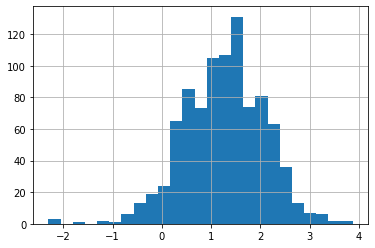

In [7]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

c:\users\alizm\documents\flatironinstitute\sk-stan-regression\scikit_stan\utils\validation.py:226: UserWarning: Passed data is one-dimensional, while estimator expects it to be at at least two-dimensional.
  warnings.warn(
c:\users\alizm\documents\flatironinstitute\sk-stan-regression\scikit_stan\generalized_linear_regression\glm.py:434: UserWarning: Prior on intercept not specified. Using default prior.
                alpha ~ normal(mu(y), 2.5 * sd(y)) if Gaussian family else normal(0, 2.5)
  warnings.warn(
c:\users\alizm\documents\flatironinstitute\sk-stan-regression\scikit_stan\generalized_linear_regression\glm.py:468: UserWarning: Prior on auxiliary parameter not specified. Using default unscaled prior
                        sigma ~ exponential(1)
                    
  warnings.warn(
20:13:27 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)




chain 1 |████      | 00:00 Iteration


20:13:31 - cmdstanpy - INFO - CmdStan done processing.
20:13:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
Consider re-running with show_console=True if the above output is unclear!


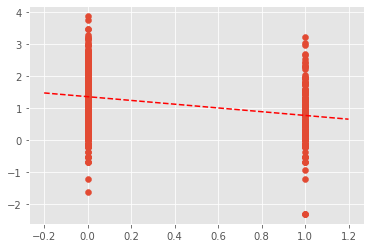

In [10]:
glm = GLM(family="gaussian", link="identity")

fitted = glm.fit(floor_measure, log_radon)
xvals = np.linspace(-0.2, 1.2)
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))

plt.plot(xvals, fitted.alpha_ + fitted.beta_*xvals, 'r--') 


##### Varying Slope Model 

In [9]:
%%capture
# this actually is a hyperhyperparameter optimization problem
# optimize over prior_aux_param, which is a hyperhyperparameter 
# as it is the hyperparameter for the prior for sigma, which is used 
# as a parameter in the family distribution   
glm_opt = GLM(family="gaussian", link="identity")

param_range = np.linspace(0.1, 1, 5)

param_grid = {
        "prior_aux" :
            list({
                "prior_aux_dist": "exponential", 

                "prior_aux_param": aux_val
            }
            for aux_val in param_range)
}


grid_search = GridSearchCV(glm, param_grid=param_grid);

searched = grid_search.fit(floor_measure, log_radon);


print(grid_search.cv_results_)

#fitted = glm.fit(X=floor_measure, y=log_radon);

#fitted.alpha_, fitted.beta_, fitted.sigma_

14:55:26 - cmdstanpy - INFO - CmdStan start processing
14:55:29 - cmdstanpy - INFO - CmdStan done processing.
14:55:32 - cmdstanpy - INFO - Chain [1] start processing
14:55:32 - cmdstanpy - INFO - Chain [2] start processing
14:55:32 - cmdstanpy - INFO - Chain [3] start processing
14:55:32 - cmdstanpy - INFO - Chain [4] start processing
14:55:39 - cmdstanpy - INFO - Chain [4] done processing
14:55:39 - cmdstanpy - INFO - Chain [2] done processing
14:55:39 - cmdstanpy - INFO - Chain [3] done processing
14:55:39 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - CmdStan start processing
14:55:43 - cmdstanpy - INFO - CmdStan done processing.
14:55:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/sk_stan_regression/stan_files/glm_v_continuous.stan', line 74, column 4 to column 35)
	Exception: normal_lpdf: Scale parameter 

In [32]:
%%capture
# this actually is a hyperhyperparameter optimization problem
# optimize over prior_aux_param, which is a hyperhyperparameter 
# as it is the hyperparameter for the prior for sigma, which is used 
# as a parameter in the family distribution   
glm_opt2 = GLM(family="gaussian", link="identity")

param_range = np.linspace(0.1, 0.5, 5)

param_grid = {
        "prior_intercept" :
            list({
                "prior_intercept_dist": "normal", 

                "prior_intercept_mu": 1.5,

                "prior_intercept_sigma": sigma_alpha_val
            }
            for sigma_alpha_val in param_range)
}


grid_search2 = GridSearchCV(glm, param_grid=param_grid);

searched = grid_search2.fit(floor_measure, log_radon);


print(grid_search.cv_results_)

#fitted = glm.fit(X=floor_measure, y=log_radon);

#fitted.alpha_, fitted.beta_, fitted.sigma_

16:09:32 - cmdstanpy - INFO - CmdStan start processing
16:09:35 - cmdstanpy - INFO - CmdStan done processing.
16:09:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/sk_stan_regression/stan_files/glm_v_continuous.stan', line 74, column 4 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/sk_stan_regression/stan_files/glm_v_continuous.stan', line 74, column 4 to column 35)
Consider re-running with show_console=True if the above output is unclear!
16:09:37 - cmdstanpy - INFO - Chain [1] start processing
16:09:37 - cmdstanpy - INFO - Chain [2] start processing
16:09:37 - cmdstanpy - INFO - Chain [3] start processing
16:09:37 - cmdstanpy - INFO - Chain [4] start processing
16:09:46 - cmdstanpy - INFO - Chain [4] done processing
16:09:46 - cmdstanpy - 

In [33]:
gs_rez2 = grid_search2.cv_results_
gs_rez2


{'mean_fit_time': array([5.63911018, 5.37399569, 5.77570066, 5.56180911, 5.52767596]),
 'std_fit_time': array([0.16018198, 0.21030081, 0.39853522, 0.17529649, 0.19464907]),
 'mean_score_time': array([9.43437424, 8.24959178, 8.43530154, 8.50664806, 8.31223288]),
 'std_score_time': array([1.1753259 , 0.3028564 , 0.42739206, 0.4264129 , 0.34747   ]),
 'param_prior_intercept': masked_array(data=[{'prior_intercept_dist': 'normal', 'prior_intercept_mu': 1.5, 'prior_intercept_sigma': 0.1},
                    {'prior_intercept_dist': 'normal', 'prior_intercept_mu': 1.5, 'prior_intercept_sigma': 0.2},
                    {'prior_intercept_dist': 'normal', 'prior_intercept_mu': 1.5, 'prior_intercept_sigma': 0.30000000000000004},
                    {'prior_intercept_dist': 'normal', 'prior_intercept_mu': 1.5, 'prior_intercept_sigma': 0.4},
                    {'prior_intercept_dist': 'normal', 'prior_intercept_mu': 1.5, 'prior_intercept_sigma': 0.5}],
              mask=[False, False, False, Fa

In [13]:
gs_rez = grid_search.cv_results_
gs_rez


{'mean_fit_time': array([5.30950308, 5.14737024, 5.56399112, 5.17774582, 5.22426496]),
 'std_fit_time': array([0.06107001, 0.02645618, 0.3098849 , 0.13146148, 0.09319016]),
 'mean_score_time': array([7.99337845, 7.90251842, 9.34669194, 7.75936437, 8.00935616]),
 'std_score_time': array([0.13692504, 0.11199365, 1.5159354 , 0.24906021, 0.08258889]),
 'param_prior_aux': masked_array(data=[{'prior_aux_dist': 'exponential', 'prior_aux_param': 0.1},
                    {'prior_aux_dist': 'exponential', 'prior_aux_param': 0.325},
                    {'prior_aux_dist': 'exponential', 'prior_aux_param': 0.55},
                    {'prior_aux_dist': 'exponential', 'prior_aux_param': 0.775},
                    {'prior_aux_dist': 'exponential', 'prior_aux_param': 1.0}],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'prior_aux': {'prior_aux_dist': 'exponential',
    'prior_aux_param': 0.1}},
  {'prior_aux': {'prior_aux_dist

In [8]:
mean_y = gs_rez2['mean_test_score']
plt.plot(param_range, mean_y[::-1])
plt.ylabel("Mean Test Score")
plt.xlabel(f"Prior Intercept $\sigma_\\alpha$ Parameter")
plt.title(f"Score with Gridsearch on Prior Intercept $\sigma_\\alpha$ Parameter")

NameError: name 'gs_rez2' is not defined

In [11]:
glm.fit(floor_measure, log_radon)

20:13:50 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▊        | 00:00 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)





chain 1 |███████▋  | 00:02 Iteration: 1400 / 2000 [ 70%]  (Sampling)





chain 1 |█████████ | 00:03 Iteration: 1700 / 2000 [ 85%]  (Sampling)


chain 1 |██████████| 00:03 Iteration: 1900 / 2000 [ 95%]  (Sampling)

chain 1 |██████████| 00:03 Sampling completed                       
chain 2 |██████████| 00:03 Sampling completed                       
chain 3 |██████████| 00:03 Sampling completed                       
chain 4 |██████████| 00:03 Sampling completed                       


20:13:54 - cmdstanpy - INFO - CmdStan done processing.
20:13:54 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/alizm/Documents/FlatironInstitute/sk-stan-regression/scikit_stan/stan_files/glm_v_continuous.stan', line 71, column 4 to column 35)
	Exception: normal_lp

In [25]:
glm.alpha_, glm.beta_, glm.sigma_

(1.3634094832324999, array([-0.58611448]), 0.7908575316030001)

In [13]:
import arviz as az
az.style.use("arviz-darkgrid")

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

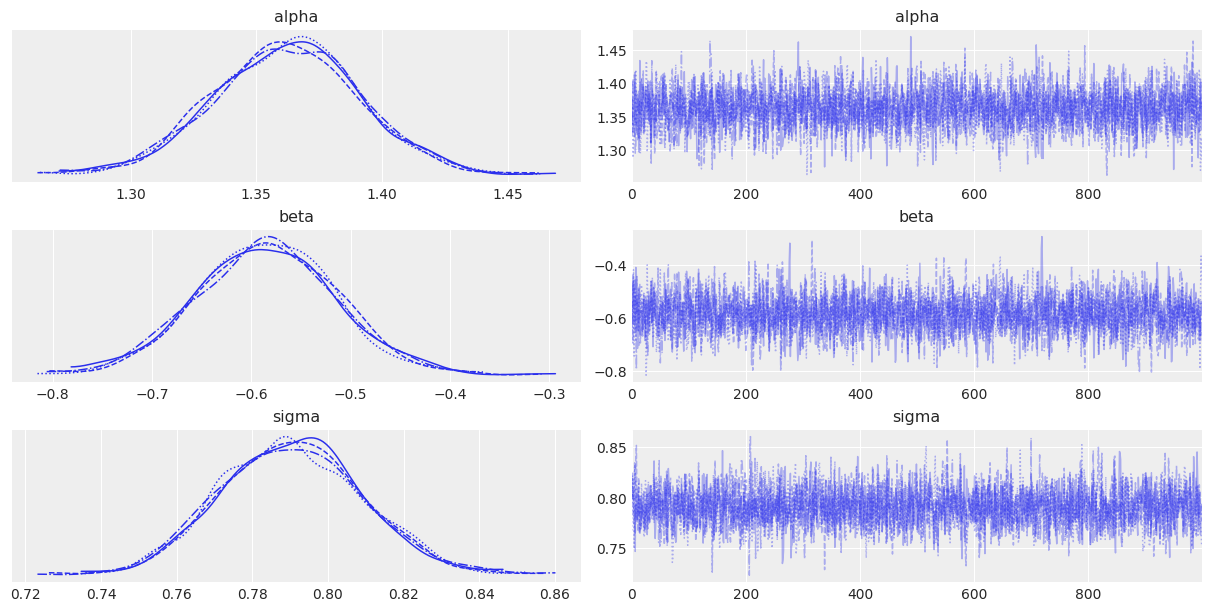

In [14]:
t =az.from_cmdstanpy(fitted.fitted_samples_)
az.plot_trace(t, var_names=["alpha", "beta", "sigma"])